In [35]:
%matplotlib inline

import math
import time
import numpy as np
import imageio
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os
import pytesseract
import cv2
import re
from PIL import Image, ImageFont, ImageDraw

pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from art.estimators.classification import BlackBoxClassifier
from art.defences.preprocessor import JpegCompression
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
def compress_image(img):
    ht, wid, _ = img.shape
    reduce_factor = math.ceil(ht/250)
    print(reduce_factor)
    new_ht = int(ht/reduce_factor)
    new_wid = int(wid/reduce_factor)
    res = cv2.resize(img, dsize=(new_wid, new_ht), interpolation=cv2.INTER_CUBIC)
    print(img.shape)
    print(res.shape)
    return res

def predict(x):
    out_label = []
    for x_i in x:
        x_i = x_i.astype(np.uint8)
        out_string = pytesseract.image_to_string(x_i).strip()
#         print(out_string)
        rmv_words_lst = ['\n']
        for rmv_word in rmv_words_lst:
            out_string = out_string.replace('\n',' ')
        out_string = re.split(', | |_|-|/|!|\+', out_string)
#         print(out_string)
        interest_word_lst = ['vaccine','vaccines','vaccination','vaccinations']
        found = 0
        for word in out_string:
            if word.lower() in interest_word_lst:
                found = 1
                break
        if found == 1:
            out_label.append(0)
        else:
            out_label.append(1)
    out_label_cat = to_categorical(out_label, 2)
    return out_label_cat

def predict_text(model, image, label_dict):
    plt.imshow(image[:,:,0])
    plt.show()
    image_lst = np.array([image], dtype=np.float32)
    out_label_cat = model.predict(image_lst)
    print(label_dict[np.argmax(out_label_cat)])

def create_mask(model, image_target, label_dict):
    attack = HopSkipJump(classifier=model, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
    iter_step = 10
    l2_error_lst = []
    x_adv = None
    for i in range(1):
        x_adv = attack.generate(x=np.array([image_target], dtype=np.float32), x_adv_init=x_adv, resume=True)
        l2_error = np.linalg.norm(np.reshape(x_adv[0]-image_target,[-1]))
        l2_error_lst.append(l2_error)
        print("Adversarial image at step %d." % (i*iter_step))
        print("L2 error: %.6f" %l2_error)
        print("Tesseract output is: %s." % label_dict[np.argmax(model.predict(x_adv)[0])])
        plt.imshow(x_adv[0,:,:,0])
        plt.show(block=False)
        attack.max_iter = iter_step
        if i>=1 and abs(l2_error_lst[-2]-l2_error_lst[-1])/l2_error_lst[-2]<0.2:
            break
    return x_adv, l2_error_lst

def verify_output(adv_img):
    adv_img_copy = adv_img.astype(np.uint8)
    plt.imshow(adv_img_copy[0,:,:,:])
    print('After perturbation')
    plt.show()
    print("Tesseract output: "+pytesseract.image_to_string(adv_img_copy[0]))

1
3
(720, 1280, 3)
(240, 426, 3)


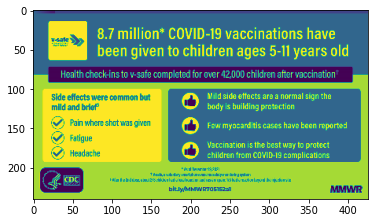

vaccination


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.12s/it]


Adversarial image at step 0.
L2 error: 8925.425781
Tesseract output is: other.


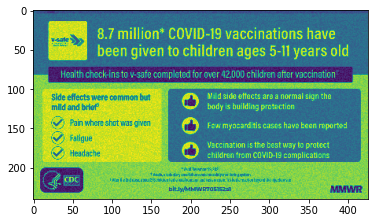

After perturbation


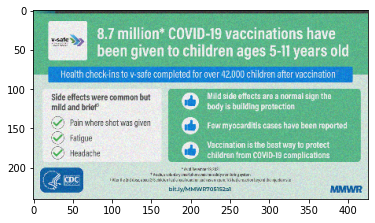

Tesseract output: Side effects were common but.
mild and brit

{Pain nee sot vas given
Q rig

© tewiae




Lossy conversion from float32 to uint8. Range [0.019242556765675545, 254.9996337890625]. Convert image to uint8 prior to saving to suppress this warning.


--- 3.9993042945861816 seconds ---
2
3
(720, 1280, 4)
(240, 426, 4)


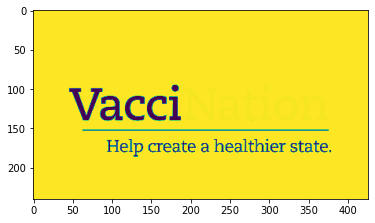

vaccination


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


Adversarial image at step 0.
L2 error: 38140.046875
Tesseract output is: other.


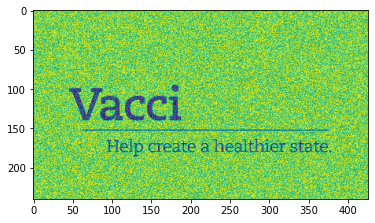

After perturbation


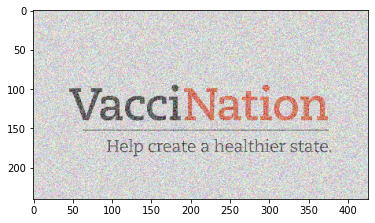

Lossy conversion from float32 to uint8. Range [0.013116377405822277, 254.9998779296875]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: 
--- 2.271838903427124 seconds ---
3
3
(720, 1280, 3)
(240, 426, 3)


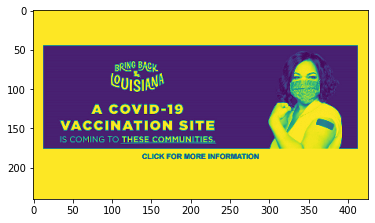

vaccination


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Adversarial image at step 0.
L2 error: 37682.250000
Tesseract output is: other.


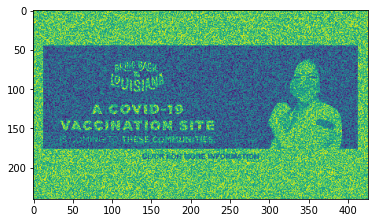

After perturbation


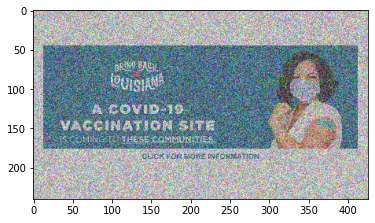

Lossy conversion from float32 to uint8. Range [0.13989971578121185, 254.9996337890625]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: 
--- 2.5538220405578613 seconds ---
4
3
(720, 1280, 3)
(240, 426, 3)


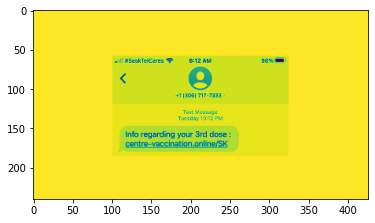

other


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.05s/it]


Adversarial image at step 0.
L2 error: 0.000000
Tesseract output is: other.


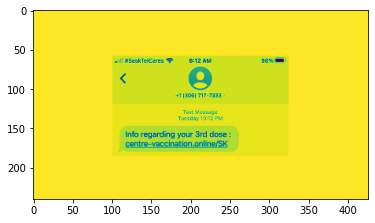

After perturbation


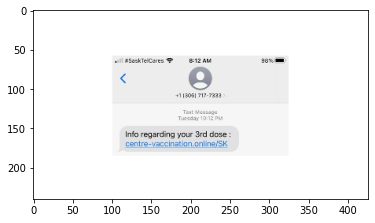

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: wo nchoeses ® ean —_

< @e

Info regarding your 3d dose
‘centre=vaccination.online/SK

--- 12.121603012084961 seconds ---
5
3
(720, 1280, 3)
(240, 426, 3)


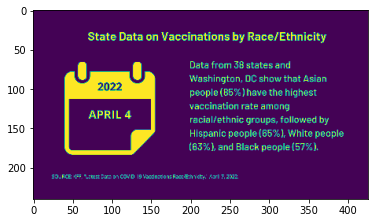

vaccination


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.81s/it]


Adversarial image at step 0.
L2 error: 29068.914062
Tesseract output is: other.


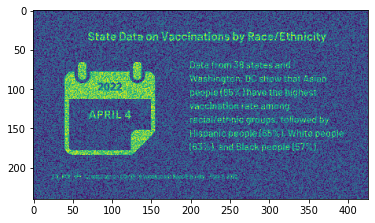

After perturbation


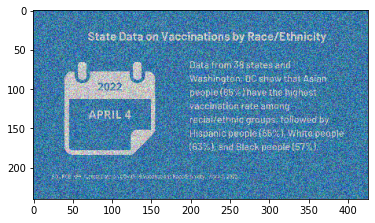

Lossy conversion from float32 to uint8. Range [0.021499045193195343, 254.9989013671875]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: 
--- 3.311001777648926 seconds ---
6
3
(720, 1280, 3)
(240, 426, 3)


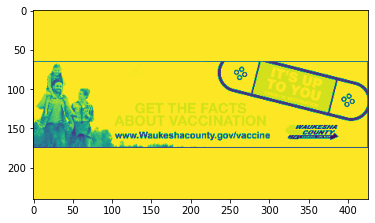

vaccination


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


Adversarial image at step 0.
L2 error: 30586.304688
Tesseract output is: other.


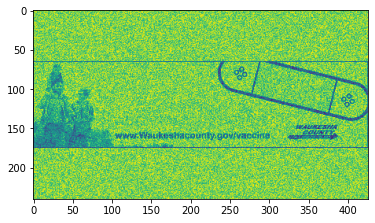

After perturbation


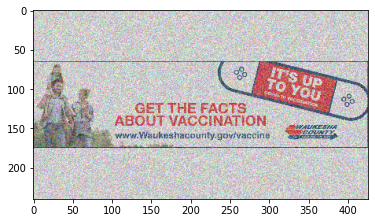

Lossy conversion from float32 to uint8. Range [0.20512226223945618, 254.99998474121094]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: 
--- 2.570283889770508 seconds ---
7
3
(720, 1280, 3)
(240, 426, 3)


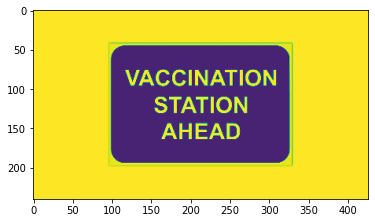

vaccination


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Adversarial image at step 0.
L2 error: 36884.257812
Tesseract output is: other.


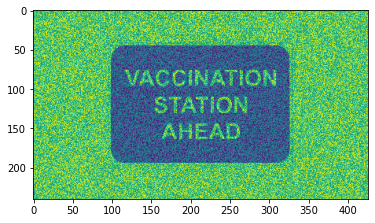

After perturbation


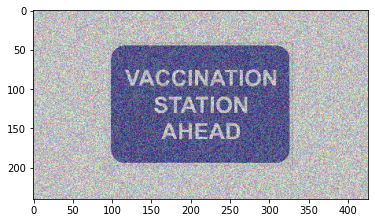

Lossy conversion from float32 to uint8. Range [14.25493335723877, 254.99948120117188]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: TATION
AHEAD


--- 2.490694761276245 seconds ---
8
3
(720, 1280, 3)
(240, 426, 3)


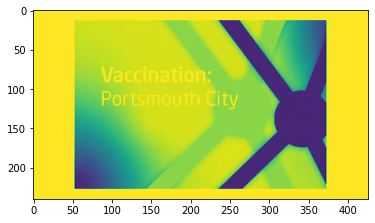

other


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.23s/it]


Adversarial image at step 0.
L2 error: 0.000000
Tesseract output is: other.


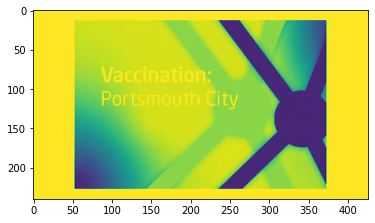

After perturbation


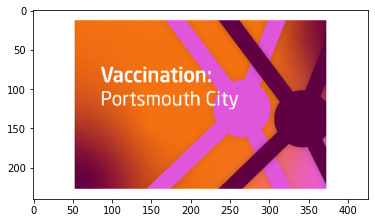

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: 
--- 12.962405920028687 seconds ---
9
3
(720, 1280, 3)
(240, 426, 3)


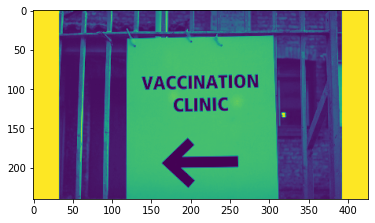

other


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.92s/it]


Adversarial image at step 0.
L2 error: 0.000000
Tesseract output is: other.


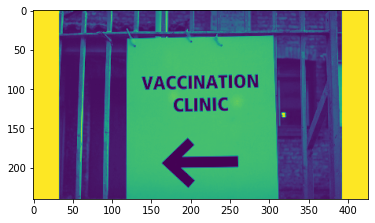

After perturbation


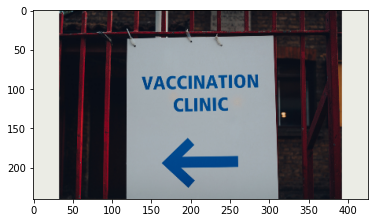

Lossy conversion from float32 to uint8. Range [0.0, 236.0]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: 
--- 12.411357879638672 seconds ---
10
3
(720, 1280, 3)
(240, 426, 3)


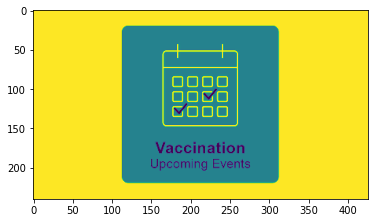

other


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.46s/it]


Adversarial image at step 0.
L2 error: 0.000000
Tesseract output is: other.


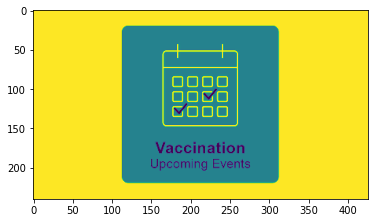

After perturbation


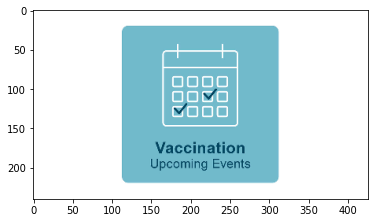

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: 
--- 12.353011846542358 seconds ---
11
3
(575, 1023, 3)
(191, 341, 3)


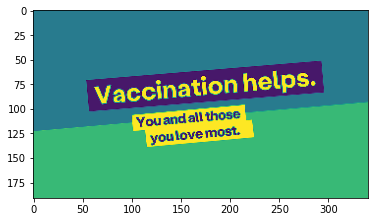

vaccination


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Adversarial image at step 0.
L2 error: 10131.825195
Tesseract output is: other.


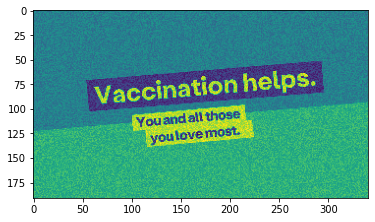

After perturbation


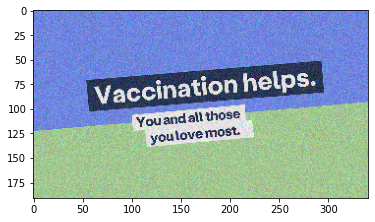

Lossy conversion from float32 to uint8. Range [0.10924316942691803, 254.99855041503906]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: Va cination helps.
"Youandalt those poe
youtovernost-


--- 2.5977559089660645 seconds ---
12
2
(400, 1080, 4)
(200, 540, 4)


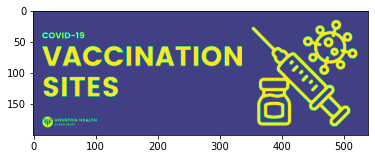

vaccination


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Adversarial image at step 0.
L2 error: 24815.968750
Tesseract output is: other.


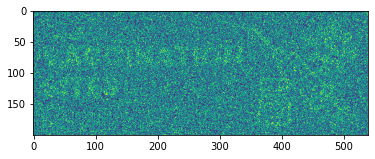

After perturbation


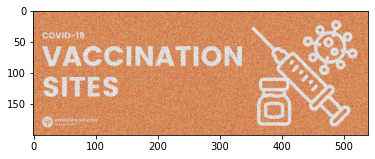

Lossy conversion from float32 to uint8. Range [0.916632890701294, 254.99981689453125]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: VACCINATION.
Ss


--- 2.6406149864196777 seconds ---
13
1
(175, 288, 3)
(175, 288, 3)


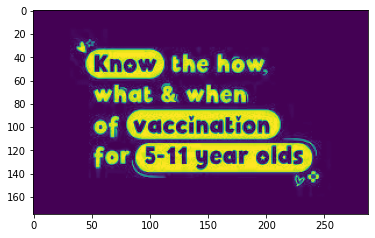

other


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.78s/it]


Adversarial image at step 0.
L2 error: 0.000000
Tesseract output is: other.


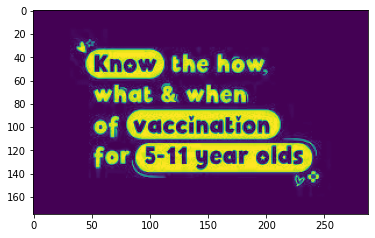

After perturbation


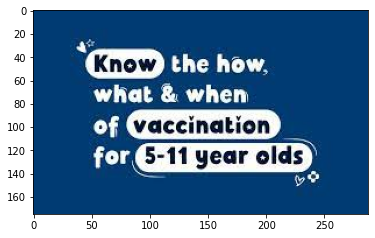

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: knowl Crd

what & when
of
Lid 5 5-11 year olds }

--- 11.014797925949097 seconds ---
14
1
(185, 272, 3)
(185, 272, 3)


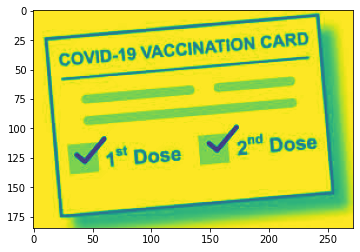

other


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.90s/it]


Adversarial image at step 0.
L2 error: 0.000000
Tesseract output is: other.


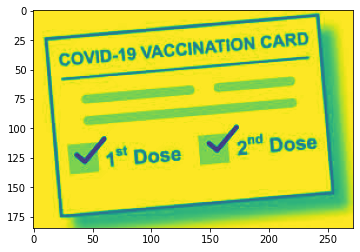

After perturbation


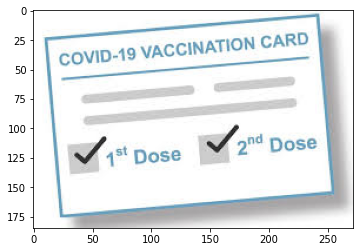

Lossy conversion from float32 to uint8. Range [2.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: 
--- 10.157904863357544 seconds ---
15
2
(336, 754, 3)
(168, 377, 3)


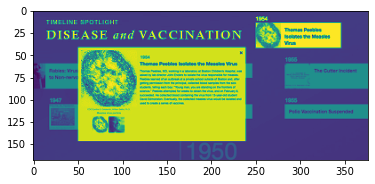

other


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.76s/it]


Adversarial image at step 0.
L2 error: 0.000000
Tesseract output is: other.


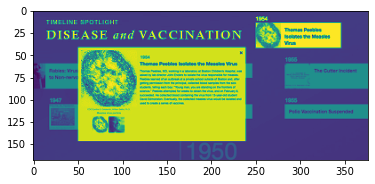

After perturbation


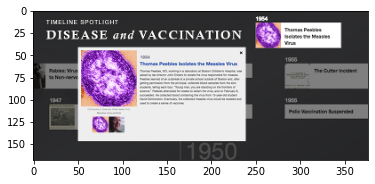

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Tesseract output: 
--- 11.976015090942383 seconds ---
16
2
(300, 980, 4)
(150, 490, 4)


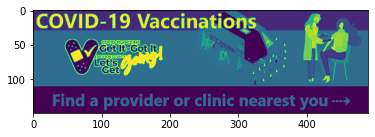

other


HopSkipJump:   0%|                                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

In [ ]:
#Text that you want to show on the image
target_word = 'vaccination'
label_dict = {0: target_word, 1: 'other'}

for i in range(1,20):
    input_img_path = './Images/Vaccination/vaccination_'+str(i)+'.png'
    if os.path.exists(input_img_path):
        print(i)
        start_time = time.time()
        image_target = imageio.imread(input_img_path)
        image_target = compress_image(image_target)
        model = BlackBoxClassifier(predict, image_target.shape, 2, clip_values=(0, 255))
        predict_text(model, image_target, label_dict)
        adv_img, l2_error_lst = create_mask(model, image_target, label_dict)
        verify_output(adv_img)
        perturbed_image_path = './Images/Untarget_attack/vaccination_'+str(i)+'_perturbed_1.png'
        imageio.imwrite(perturbed_image_path, adv_img[0])
        print("--- %s seconds ---" % (time.time() - start_time))